In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator

import scipy as scp
from scipy import stats


import pandas as pd

import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


(0.0, 47.0)

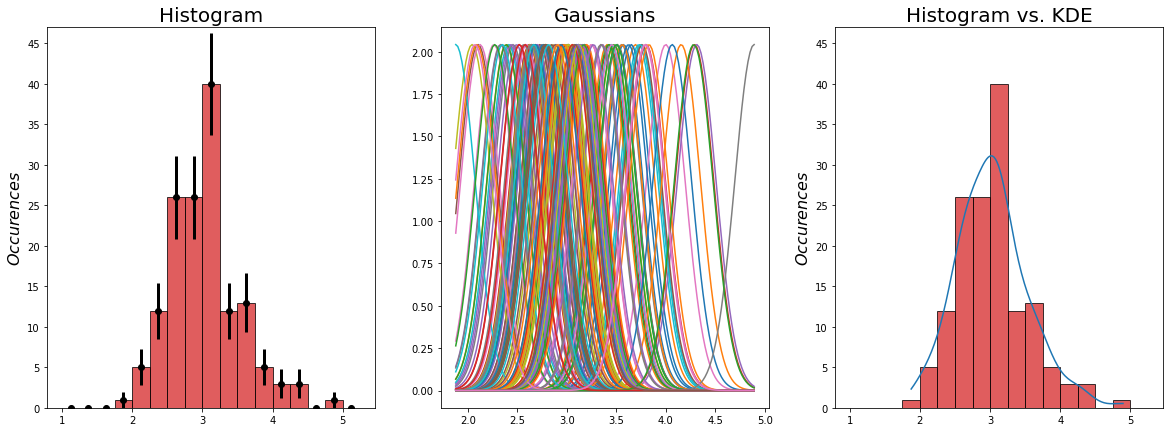

In [2]:

N = 147
mean=3
dev=5e-1

x = np.random.normal(mean , dev , N)


fig, (ax1 , ax2 , ax3) = plt.subplots(nrows=1 , ncols=3 , figsize=(20, 7))

#HISTO


ax1.set_title('Histogram' , fontsize = 20)
ax1.set_ylabel('$Occurences$' , fontsize = 16)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

bins = np.arange(mean - 4*dev, mean + 5*dev , dev/2)

counts, _ , _ = ax1.hist(x, bins , alpha=0.75 , color='tab:red', edgecolor='black')


x_pos = [(x1+x2)*0.5 for x1, x2 in zip(bins[:-1], bins[1:])]
err_list     = [np.sqrt(n) for n in counts]

ax1.errorbar(x_pos, counts, err_list, fmt='o', c='black', ecolor='black', elinewidth=3, capsize=0)
ax1.set_ylim([0,counts.max()+int(np.sqrt(counts.max()))+1])


#GAUSSIANS

X = np.linspace(x.min(), x.max(), 147)
gaussians=[]


for p in x:
    gaussians.append(stats.norm.pdf(X, p , 1.06*dev*(N**(-1/5))))
    ax2.plot(X, gaussians[-1])

ax2.set_title('Gaussians' , fontsize = 20)




#SUM and Normalize
gauss_sum = np.sum(gaussians, axis=0)
gauss_area = scp.integrate.trapz(gauss_sum , dx = abs(x.max() - x.min())/N)
hist_area  = np.sum(np.diff(bins)*counts)

ax3.set_ylabel('$Occurences$' , fontsize = 16)
ax3.set_title('Histogram vs. KDE' , fontsize = 20)

ax3.yaxis.set_major_locator(MaxNLocator(integer = True))

ax3.plot(X, (gauss_sum/gauss_area)*hist_area)

ax3.hist(x, bins , alpha=0.75, color='tab:red', edgecolor='black')

ax3.set_ylim([0,counts.max()+int(np.sqrt(counts.max()))+1])



2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

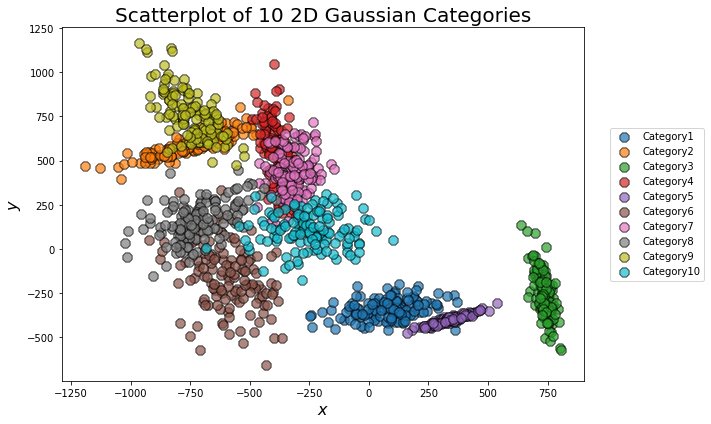

In [53]:

def gen_n_cat(n , mean_interv, cov_interv , N):
    
    dataset = []
    
    t=0
    for j in range(n):
        cov = np.random.uniform(cov_interv[0],  cov_interv[1], (2,2))
        
        g = np.random.multivariate_normal(np.random.uniform(mean_interv[0],  mean_interv[1], 2) +
                                           np.random.uniform(m_shift[0],  m_shift[1], 2), 
                                                np.dot(cov, np.transpose(cov)), N)
                                                
        df=pd.DataFrame()
        df['x'] , df['y'] = g[:,0], g[:,1]
        dataset.append(df)

    return dataset
    
    
n_cat=10

means = [ -777 , 777 ]
m_shift =[0,23]

covs = [-150 , 150]


data = gen_n_cat(n_cat , means, covs, 133)


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Scatterplot of %i 2D Gaussian Categories'%(n_cat) , fontsize=20)
ax.set_xlabel('$x$' , fontsize=16)
ax.set_ylabel('$y$' , fontsize=16)
box = ax.get_position()



for i in range(n_cat):
    
    ax.scatter(data[i]['x'], data[i]['y'], s=100 , marker='8', alpha=0.7,  edgecolor='black', label='Category%i'%(i+1))
    
ax.legend(loc='center left' , bbox_to_anchor=(1.04, 0.5))
fig.tight_layout()

--2021-12-02 10:02:54--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2021-12-02 10:02:54--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc4f65952647198c2b20a86c49b2.dl.dropboxusercontent.com/cd/0/inline/BbFXSWdR38pY-NHnuC8BMtn_AG-zajT05xc_ioUPHhb_ns5kpqs1JmuSlV-Ek32SqYhNwfDdj5QpQws0qGx2xe0Ktgdo67sLYwr9apJ8l54t0ON_yR6vfqQUFQc9ZcZms4FDokOnTAtY2O5uoaTl-e-V/file# [segue]
--2021-12-02 10:02:55--  https://uc4f65952647198c2b20a86c49b2.dl.dropboxusercontent.com/cd/0/inline/BbFX

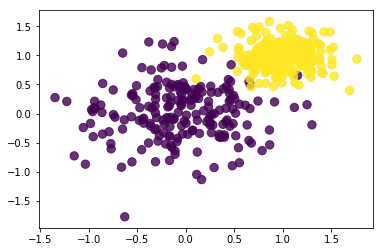

In [4]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [5]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -P /home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs6/

--2021-12-02 10:02:55--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2021-12-02 10:02:56--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc19219cf9f8b16b982ed48b29df.dl.dropboxusercontent.com/cd/0/inline/BbHqxKbtkZSfo_KDPtKBdtjdi_TW-3fgb-OrrA1fcjGojWTLkon5N4Ze7BgvWRffR9-nIBNCNQtMcf-WEl-DlYHtfbtj7ksDP98NJpjpXDpN3TUiqxJM2IHg9swhqbb3K5w0VmG5D1ORrMxqryx_1-4k/file# [segue]
--2021-12-02 10:02:56--  https://uc19219cf9f8b16b982ed48b29df.dl.dropboxusercontent.com/cd/0/inline/BbHqxKbtkZSfo_KDPtKBdtjdi_TW-3fgb-OrrA1fcjGojW

In [6]:
#Load and Inspect the dataset


array = np.load('dataEs6/residuals_261.npy', allow_pickle=True)

dataf = pd.DataFrame(array.item())
print(dataf.info)

dataf.head(5)

<bound method DataFrame.info of        residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
2      -7.200000        3.4
3      -4.150000        8.4
4      -6.590000        1.7
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[11131 rows x 2 columns]>


,residuals,distances
0,1.10,16.0
1,-1.95,6.3
2,-7.20,3.4
3,-4.15,8.4
4,-6.59,1.7


In [22]:
#Clean the sample by selecting the entries (rows) 
#with the variable "residual" in absolute value smaller than 2

dataf = dataf[ abs( dataf['residuals'] ) < 2]
dataf.head(5)

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0


Text(0.5, 0.98, 'Linear Regression')

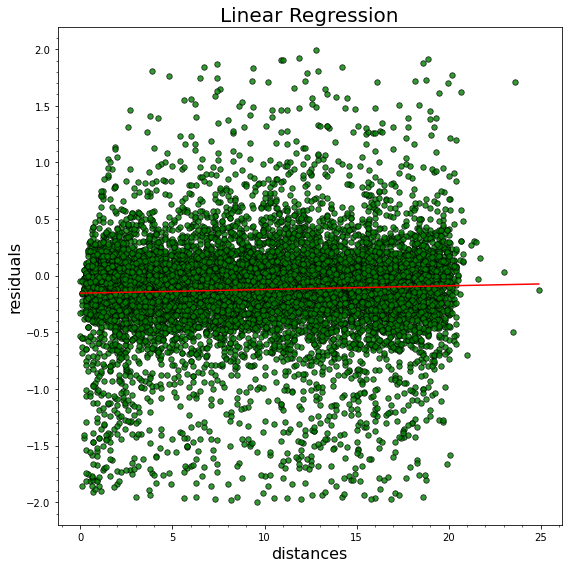

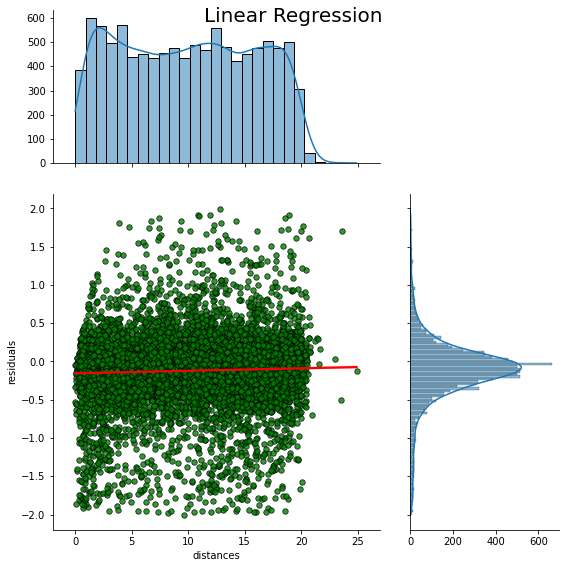

In [29]:
#perform a linear regression of "residuals" versus "distances" using scipy.stats.linregress()

lin_reg = scp.stats.linregress( dataf['distances'] , dataf['residuals'])

fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 8))

ax.scatter(dataf['distances'], dataf['residuals'], s=30, c='green', edgecolors='black', linewidths=0.8, alpha=0.8)

x_axis = np.linspace(np.min(dataf['distances']), np.max(dataf['distances']), 100)
y_axis = x_axis*lin_reg.slope +lin_reg.intercept

ax.set_title('Linear Regression' , fontsize=20)
ax.set_xlabel('distances' , fontsize=16)
ax.set_ylabel('residuals' , fontsize=16)

ax.plot(x_axis, y_axis, c='red')

ax.minorticks_on()

fig.tight_layout()


#plot a seaborn jointplot of "residuals" versus "distances", 
#having seaborn performing a linear regression. 
#The result of the regression should be displayed on the plot


p = sns.jointplot(x='distances', y='residuals', data=dataf, kind="reg", ratio=2, xlim=(-2,27) , height=8, marginal_ticks=True, joint_kws={'line_kws':{'color':'red'},'scatter_kws':{'color':'green','edgecolors':'black', 's':30,'linewidths':0.8,'alpha':0.8}})
p.fig.suptitle('Linear Regression' , fontsize=20)



Text(0.5, 0.98, 'Linear Regression with Profile')

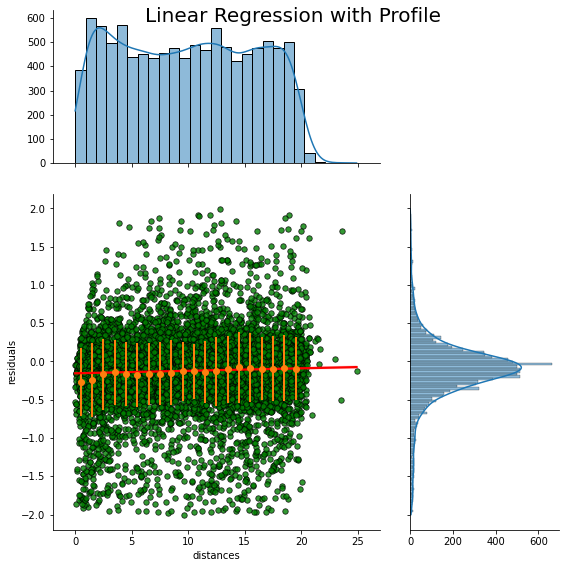

In [57]:
#Fill 3 numpy arrays 

#x, serving as an array of bin centers for the "distance" variable.
#It should range from 0 to 20 with reasonable number of steps (bins)
#y, the mean values of the "residuals", estimated in slices (bins) of "distance"
#erry, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"


step_center=0.5

x = [i + step_center for i in range(20)]


y = [ np.mean( dataf[dataf['distances'].between(step_center*b - step_center , step_center*b + step_center)]['residuals']) for b in range(20)]


erry = [ np.std( dataf[dataf['distances'].between(step_center*b - step_center , step_center*b + step_center)]['residuals']) for b in range(20)]



#Plot the profile plot on top of the scatter plot


p = sns.jointplot(x='distances', y='residuals', data=dataf, kind="reg", ratio=2, xlim=(-2,27) , height=8, marginal_ticks=True, joint_kws={'line_kws':{'color':'red'},'scatter_kws':{'color':'green','edgecolors':'black', 's':30,'linewidths':0.8,'alpha':0.8}})
p.ax_joint.errorbar(x, y, erry, c='tab:orange', fmt='o', ecolor='tab:orange', label='Error bars', elinewidth=2)
p.fig.suptitle('Linear Regression with Profile' , fontsize=20)



